### **Importing Libraries**

In [ ]:
# Basic Libraries
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import scipy
from scipy.fft import fft, fftfreq
import seaborn as sns

# Audio Related Libraries
from IPython.display import clear_output
import librosa
from IPython.display import Audio

# DL Libraries
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,  classification_report


### **Creating Dataset**

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzipping Dataset

!unzip '/content/gdrive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 03 | Speech Information Processing/clean_speech.zip'
!unzip '/content/gdrive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 03 | Speech Information Processing/noisy_speech.zip'
!unzip '/content/gdrive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 03 | Speech Information Processing/rir.zip'

Archive:  /content/gdrive/MyDrive/E9 222 Signal Processing in Practice Assignments/Assignment - 03 | Speech Information Processing/clean_speech.zip
   creating: clean_speech/
   creating: clean_speech/train/
  inflating: clean_speech/train/SUB095_SS_20.wav  
  inflating: clean_speech/train/SUB095_SS_21.wav  
  inflating: clean_speech/train/SUB095_UU_20.wav  
  inflating: clean_speech/train/SUB095_AA_30.wav  
  inflating: clean_speech/train/SUB095_FF_30.wav  
  inflating: clean_speech/train/SUB095_II_30.wav  
  inflating: clean_speech/train/SUB095_II_31.wav  
  inflating: clean_speech/train/SUB095_FF_10.wav  
  inflating: clean_speech/train/SUB095_UU_30.wav  
  inflating: clean_speech/train/SUB095_UU_31.wav  
  inflating: clean_speech/train/SUB095_II_10.wav  
  inflating: clean_speech/train/SUB095_II_11.wav  
  inflating: clean_speech/train/SUB095_SH_30.wav  
  inflating: clean_speech/train/SUB095_AA_10.wav  
  inflating: clean_speech/train/SUB095_SH_20.wav  
  inflating: clean_speech/t

In [ ]:
# Creating Train and Test Dataset

def get_files(path):
    files = os.listdir(path)
    files = [os.path.join(path, f) for f in files]
    # print(f'{len(files)} files found in {path}')
    return files

def create_dataset(path, class_type):

    if class_type == 'vowels':
        label_dictionary = {'AA':0, 'II':1, 'UU':2}
    else:
        label_dictionary = { 'SS':0, 'SH': 1, 'FF':2}
    filepaths = get_files(path)
    labels = []
    X = []

    for audiofile_path in filepaths:
        label = audiofile_path[:-16:-1].split('_')[1][::-1]
        if label not in label_dictionary.keys():
            continue
        labels.append(label_dictionary[label])   # Taking the last 16 charachters of filepath and splitting by '_' to find phenome
        audio, sr = librosa.load(audiofile_path)
        X.append(audio)

    print(f'{len(X)} {class_type} files found in {path}')
    return np.array(X), np.array(labels), sr

clean_train_path = '/content/clean_speech/train/'
clean_test_path = '/content/clean_speech/test/'
noisy_train_path = '/content/noisy_speech/train/'
noisy_test_path = '/content/noisy_speech/test/'

vowel_class_names = ['AA', 'II', 'UU']
consonant_class_names = ['SS', 'SH', 'FF']

clean_train_vowels_data, clean_train_vowels_labels, clean_train_vowels_sampling_rate = create_dataset(clean_train_path, 'vowels')
clean_test_vowels_data, clean_test_vowels_labels, clean_test_vowels_sampling_rate = create_dataset(clean_test_path, 'vowels')
noisy_train_vowels_data, noisy_train_vowels_labels, noisy_train_vowels_sampling_rate = create_dataset(noisy_train_path, 'vowels')
noisy_test_vowels_data, noisy_test_vowels_labels, noisy_test_vowels_sampling_rate = create_dataset(noisy_test_path, 'vowels')

clean_train_consonants_data, clean_train_consonants_labels, clean_train_consonants_sampling_rate = create_dataset(clean_train_path, 'consonants')
clean_test_consonants_data, clean_test_consonants_labels, clean_test_consonants_sampling_rate = create_dataset(clean_test_path, 'consonants')
noisy_train_consonants_data, noisy_train_consonants_labels, noisy_train_consonants_sampling_rate = create_dataset(noisy_train_path, 'consonants')
noisy_test_consonants_data, noisy_test_consonants_labels, noisy_test_consonants_sampling_rate = create_dataset(noisy_test_path, 'consonants')

584 vowels files found in /content/clean_speech/train/
354 vowels files found in /content/clean_speech/test/
584 vowels files found in /content/noisy_speech/train/
354 vowels files found in /content/noisy_speech/test/
336 consonants files found in /content/clean_speech/train/
203 consonants files found in /content/clean_speech/test/
336 consonants files found in /content/noisy_speech/train/
203 consonants files found in /content/noisy_speech/test/


In [ ]:
# Reverberation Dictionary

Reverb = {}
reverberation_paths = get_files('/content/rir/')

for path in reverberation_paths:
    reverb_type = path[31:-4]
    reverb_response, sr = librosa.load(path)
    Reverb[reverb_type] = reverb_response

print(Reverb.keys())

dict_keys(['smallroom1_far_anglb', 'mediumroom1_near_angla', 'mediumroom1_far_angla', 'smallroom1_near_angla', 'smallroom1_near_anglb', 'mediumroom1_far_anglb', 'largeroom1_near_anglb', 'mediumroom1_near_anglb', 'largeroom1_near_angla', 'smallroom1_far_angla', 'largeroom1_far_angla', 'largeroom1_far_anglb'])


In [ ]:
# Creating Spectrogram Datasets

NPERSEG = 256
WINDOW = 'hann'

def get_spectrogram_dataset(audio_dataset, sampling_rate, nperseg, window):

    X = []

    for signal in audio_dataset:

        # f, t, audio_spectrogram = scipy.signal.spectrogram(signal, sampling_rate, nperseg = nperseg, noverlap = 0, mode = 'psd', window = window)
        audio_spectrogram = np.abs(librosa.stft(y = signal, n_fft = NPERSEG, hop_length=256, window = 'hann'))
        X.append(audio_spectrogram)

    return np.array(X)

clean_spectrogram_train_vowels_dataset = get_spectrogram_dataset(clean_train_vowels_data, clean_train_vowels_sampling_rate, NPERSEG, WINDOW)
clean_spectrogram_test_vowels_dataset = get_spectrogram_dataset(clean_test_vowels_data, clean_test_vowels_sampling_rate, NPERSEG, WINDOW)
noisy_spectrogram_train_vowels_dataset = get_spectrogram_dataset(noisy_train_vowels_data, noisy_train_vowels_sampling_rate, NPERSEG, WINDOW)
noisy_spectrogram_test_vowels_dataset = get_spectrogram_dataset(noisy_test_vowels_data, noisy_test_vowels_sampling_rate, NPERSEG, WINDOW)

clean_spectrogram_train_consonants_dataset = get_spectrogram_dataset(clean_train_consonants_data, clean_train_consonants_sampling_rate, NPERSEG, WINDOW)
clean_spectrogram_test_consonants_dataset = get_spectrogram_dataset(clean_test_consonants_data, clean_test_consonants_sampling_rate, NPERSEG, WINDOW)
noisy_spectrogram_train_consonants_dataset = get_spectrogram_dataset(noisy_train_consonants_data, noisy_train_consonants_sampling_rate, NPERSEG, WINDOW)
noisy_spectrogram_test_consonants_dataset = get_spectrogram_dataset(noisy_test_consonants_data, noisy_test_consonants_sampling_rate, NPERSEG, WINDOW)

## **Vowel Classification**

###  **(a) Using Clean Spectrograms**

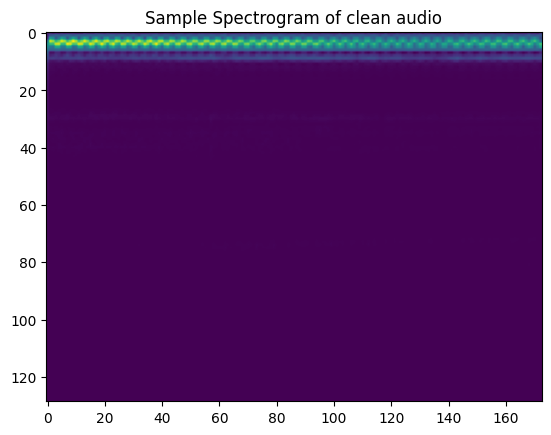

In [ ]:
# Preparing Training and Testing Dataset

x_train,  y_train = clean_spectrogram_train_vowels_dataset.copy(), clean_train_vowels_labels.copy()
x_test, y_test = clean_spectrogram_test_vowels_dataset.copy(), clean_test_vowels_labels.copy()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

n_classes = len(np.unique(y_train))
Image_shape = x_train[0].shape

plt.title('Sample Spectrogram of clean audio')
plt.imshow(x_train[0])

In [ ]:
# # Define the CNN model


# model.summary()

In [ ]:
# Define the CNN model

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 171, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 85, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 83, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 41, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 39360)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
# Compile the model
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split = 0.25)

Epoch 1/10
7/7 [==============================] - 15s 447ms/step - loss: 0.5524 - accuracy: 0.7854 - val_loss: 0.0161 - val_accuracy: 0.9932
Epoch 2/10
7/7 [==============================] - 0s 57ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0116 - accuracy: 0.9954 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0040 - accuracy: 0.9977 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 4.8684e-04 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 52ms/step - loss: 0.0022 - accuracy: 0.9977 - val_loss: 2.0962e-04 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 52ms/step - loss: 9.5154e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 8/10
7/

In [ ]:
# Evaluate the model
y_pred = np.argmax(model.predict(x_test), axis=1)
test_accuracy = metrics.accuracy_score(y_test,y_pred)
print(f'Accuracy on the Test Dataset is :{test_accuracy:.4f}')

12/12 [==============================] - 1s 14ms/step
Accuracy on the Test Dataset is :0.9972


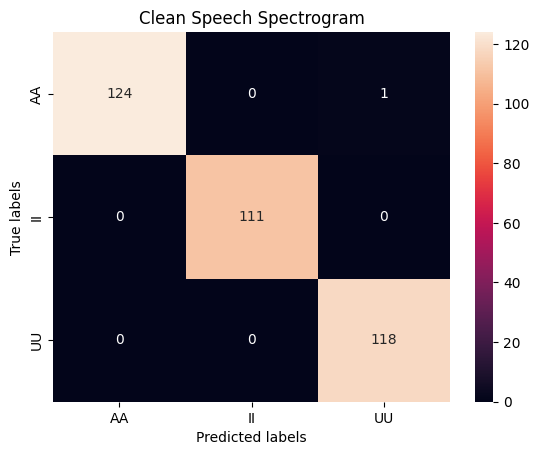

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test,y_pred)

classes = ['AA', 'II', 'UU']

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Clean Speech Spectrogram');
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

###  **(b) Using Noisy Spectrograms**

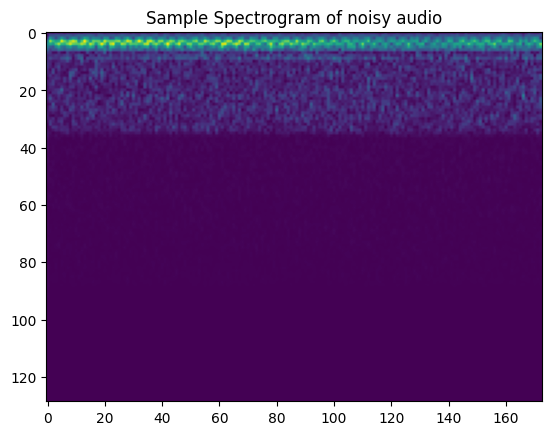

In [ ]:
# Preparing Training and Testing Dataset

x_train,  y_train = noisy_spectrogram_train_vowels_dataset.copy(), noisy_train_vowels_labels.copy()
x_test, y_test = noisy_spectrogram_test_vowels_dataset.copy(), noisy_test_vowels_labels.copy()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

n_classes = len(np.unique(y_train))
Image_shape = x_train[0].shape

plt.title('Sample Spectrogram of noisy audio')
plt.imshow(x_train[0])

In [ ]:
# Define the CNN model

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 127, 171, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 85, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 83, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 41, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 39360)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
# Compile the model
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split = 0.25)

Epoch 1/10
7/7 [==============================] - 2s 86ms/step - loss: 3.4240 - accuracy: 0.4795 - val_loss: 0.9296 - val_accuracy: 0.6644
Epoch 2/10
7/7 [==============================] - 0s 52ms/step - loss: 0.8146 - accuracy: 0.6301 - val_loss: 0.6160 - val_accuracy: 0.7260
Epoch 3/10
7/7 [==============================] - 0s 52ms/step - loss: 0.4774 - accuracy: 0.7900 - val_loss: 0.3952 - val_accuracy: 0.7877
Epoch 4/10
7/7 [==============================] - 0s 52ms/step - loss: 0.3596 - accuracy: 0.8379 - val_loss: 0.3290 - val_accuracy: 0.8219
Epoch 5/10
7/7 [==============================] - 0s 47ms/step - loss: 0.3950 - accuracy: 0.8242 - val_loss: 0.3284 - val_accuracy: 0.8356
Epoch 6/10
7/7 [==============================] - 0s 53ms/step - loss: 0.2954 - accuracy: 0.8881 - val_loss: 0.1979 - val_accuracy: 0.9041
Epoch 7/10
7/7 [==============================] - 0s 47ms/step - loss: 0.2379 - accuracy: 0.9018 - val_loss: 0.2324 - val_accuracy: 0.8836
Epoch 8/10
7/7 [===========

In [ ]:
# Evaluate the model
y_pred = np.argmax(model.predict(x_test), axis=1)
test_accuracy = metrics.accuracy_score(y_test,y_pred)
print(f'Accuracy on the Test Dataset is :{test_accuracy:.4f}')

12/12 [==============================] - 0s 5ms/step
Accuracy on the Test Dataset is :0.8051


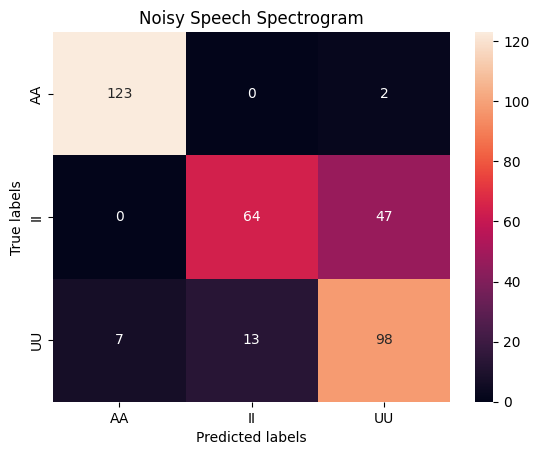

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test,y_pred)

classes = ['AA', 'II', 'UU']

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Noisy Speech Spectrogram');
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

###  **(c) Using Corrupted Rows Spectrograms of Clean Speech**

In [ ]:
# Preparing Training and Testing Dataset

x_train,  y_train = clean_spectrogram_train_vowels_dataset.copy(), clean_train_vowels_labels.copy()
x_test, y_test = clean_spectrogram_test_vowels_dataset.copy(), clean_test_vowels_labels.copy()

def corrupt_rows(dataset, percentage_of_corruption):

    for i,Sxx in enumerate(dataset):
        idx = random.sample(range(0, Sxx.shape[0]), int((percentage_of_corruption/100)*Sxx.shape[0]))
        Sxx[idx, :] = np.random.uniform(np.min(Sxx), np.max(Sxx), (len(idx),Sxx.shape[1]))
        dataset[i] = Sxx

    return dataset

x_train, x_test = corrupt_rows(x_train, 5), corrupt_rows(x_test, 5)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

n_classes = len(np.unique(y_train))
Image_shape = x_train[0].shape

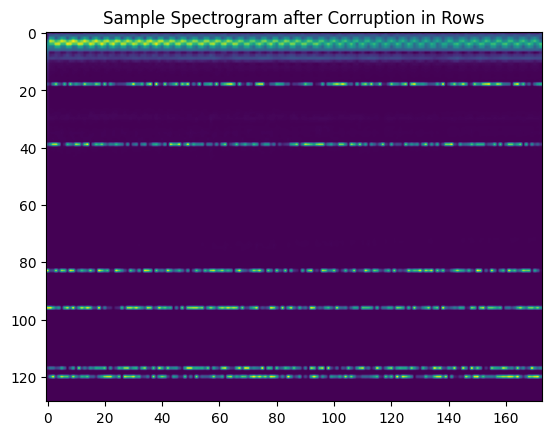

In [ ]:
plt.title('Sample Spectrogram after Corruption in Rows')
plt.imshow(x_train[0])

In [ ]:
corruption_list = [1, 5, 10, 20, 50]

def corrupt_rows(dataset, percentage_of_corruption):

    for i,Sxx in enumerate(dataset):
        idx = random.sample(range(0, Sxx.shape[0]), int((percentage_of_corruption/100)*Sxx.shape[0]))
        Sxx[idx, :] = np.random.uniform(np.min(Sxx), np.max(Sxx), (len(idx),Sxx.shape[1]))
        dataset[i] = Sxx

    return dataset

cf_matrix_list = []

for corruption in corruption_list:

    # Preparing Training and Testing Dataset
    x_train,  y_train = clean_spectrogram_train_vowels_dataset.copy(), clean_train_vowels_labels.copy()
    x_test, y_test = clean_spectrogram_test_vowels_dataset.copy(), clean_test_vowels_labels.copy()

    x_train, x_test = corrupt_rows(x_train, corruption), corrupt_rows(x_test, corruption)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape


    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Percentage of Corruption : {corruption}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 1, Test accuracy: 0.9943502824858758
12/12 [==============================] - 0s 6ms/step
Percentage of Corruption : 5, Test accuracy: 0.9745762711864406
12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 10, Test accuracy: 0.5254237288135594
12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 20, Test accuracy: 0.53954802259887
12/12 [==============================] - 0s 6ms/step
Percentage of Corruption : 50, Test accuracy: 0.3926553672316384


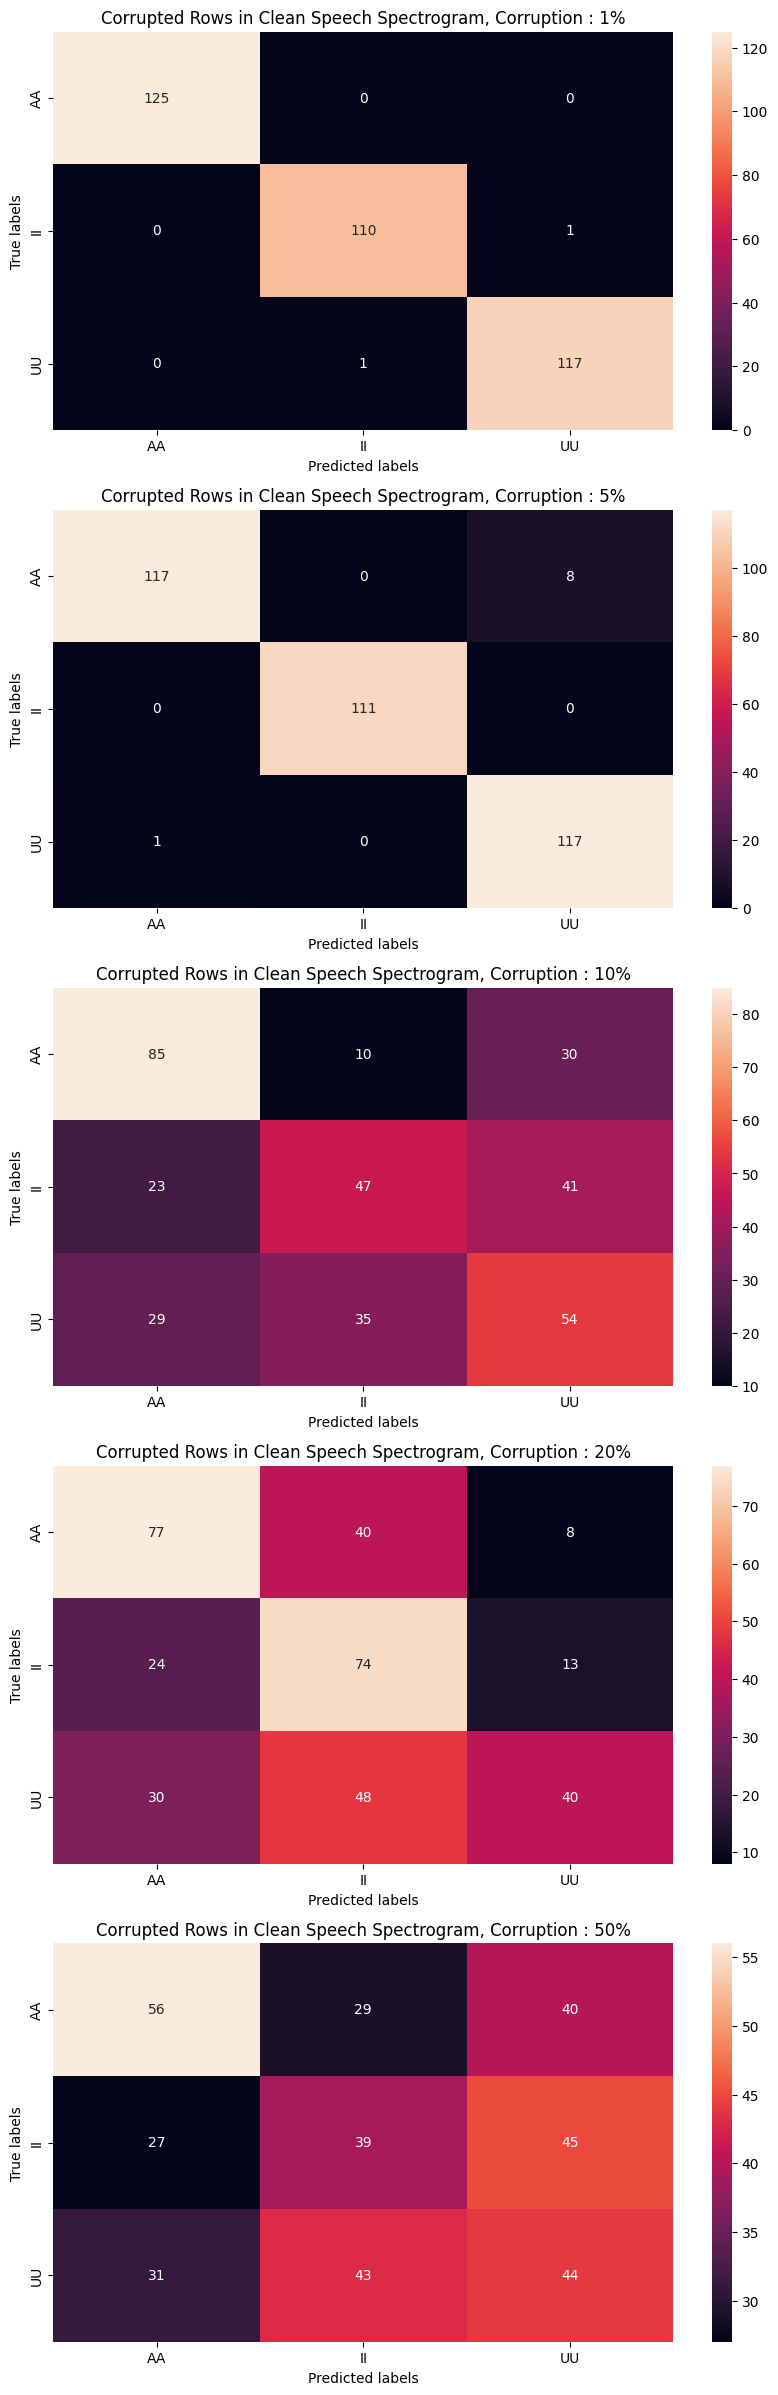

In [ ]:
classes = ['AA', 'II', 'UU']
fig, ax = plt.subplots(5,1,figsize=(10,30))

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(5,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Corrupted Rows in Clean Speech Spectrogram, Corruption : {corruption_list[i]}%')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

###  **(d) Using Corrupted Columns Spectrograms of Clean Speech**

In [ ]:
# Preparing Training and Testing Dataset

x_train,  y_train = clean_spectrogram_train_vowels_dataset.copy(), clean_train_vowels_labels.copy()
x_test, y_test = clean_spectrogram_test_vowels_dataset.copy(), clean_test_vowels_labels.copy()

def corrupt_columns(dataset, percentage_of_corruption):

    for i,Sxx in enumerate(dataset):
        idx = random.sample(range(0, Sxx.shape[1]), int((percentage_of_corruption/100)*Sxx.shape[1]))
        Sxx[:, idx] = np.random.uniform(np.min(Sxx), np.max(Sxx), (Sxx.shape[0],len(idx)))
        dataset[i] = Sxx

    return dataset

x_train, x_test = corrupt_columns(x_train, 5), corrupt_columns(x_test, 5)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

n_classes = len(np.unique(y_train))
Image_shape = x_train[0].shape

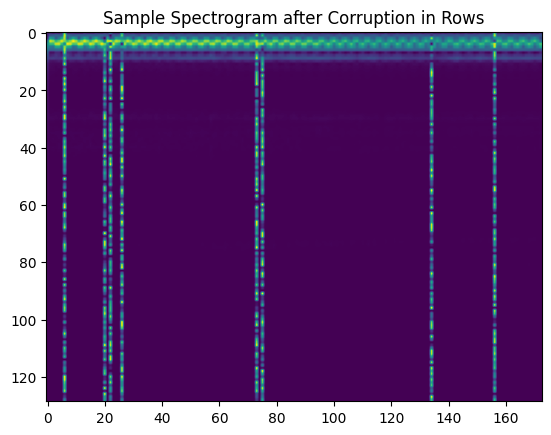

In [ ]:
plt.title('Sample Spectrogram after Corruption in Rows')
plt.imshow(x_train[0])

In [ ]:
corruption_list = [1, 5, 10, 20, 50]

def corrupt_columns(dataset, percentage_of_corruption):

    for i,Sxx in enumerate(dataset):
        idx = random.sample(range(0, Sxx.shape[1]), int((percentage_of_corruption/100)*Sxx.shape[1]))
        Sxx[:, idx] = np.random.uniform(np.min(Sxx), np.max(Sxx), (Sxx.shape[0],len(idx)))
        dataset[i] = Sxx

    return dataset

cf_matrix_list = []

for corruption in corruption_list:

    # Preparing Training and Testing Dataset
    x_train,  y_train = clean_spectrogram_train_vowels_dataset.copy(), clean_train_vowels_labels.copy()
    x_test, y_test = clean_spectrogram_test_vowels_dataset.copy(), clean_test_vowels_labels.copy()

    x_train, x_test = corrupt_columns(x_train, corruption), corrupt_columns(x_test, corruption)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape


    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Percentage of Corruption : {corruption}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

12/12 [==============================] - 0s 6ms/step
Percentage of Corruption : 1, Test accuracy: 0.9971751412429378
12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 5, Test accuracy: 0.9180790960451978
12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 10, Test accuracy: 0.8248587570621468
12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 20, Test accuracy: 0.9096045197740112
12/12 [==============================] - 0s 5ms/step
Percentage of Corruption : 50, Test accuracy: 0.672316384180791


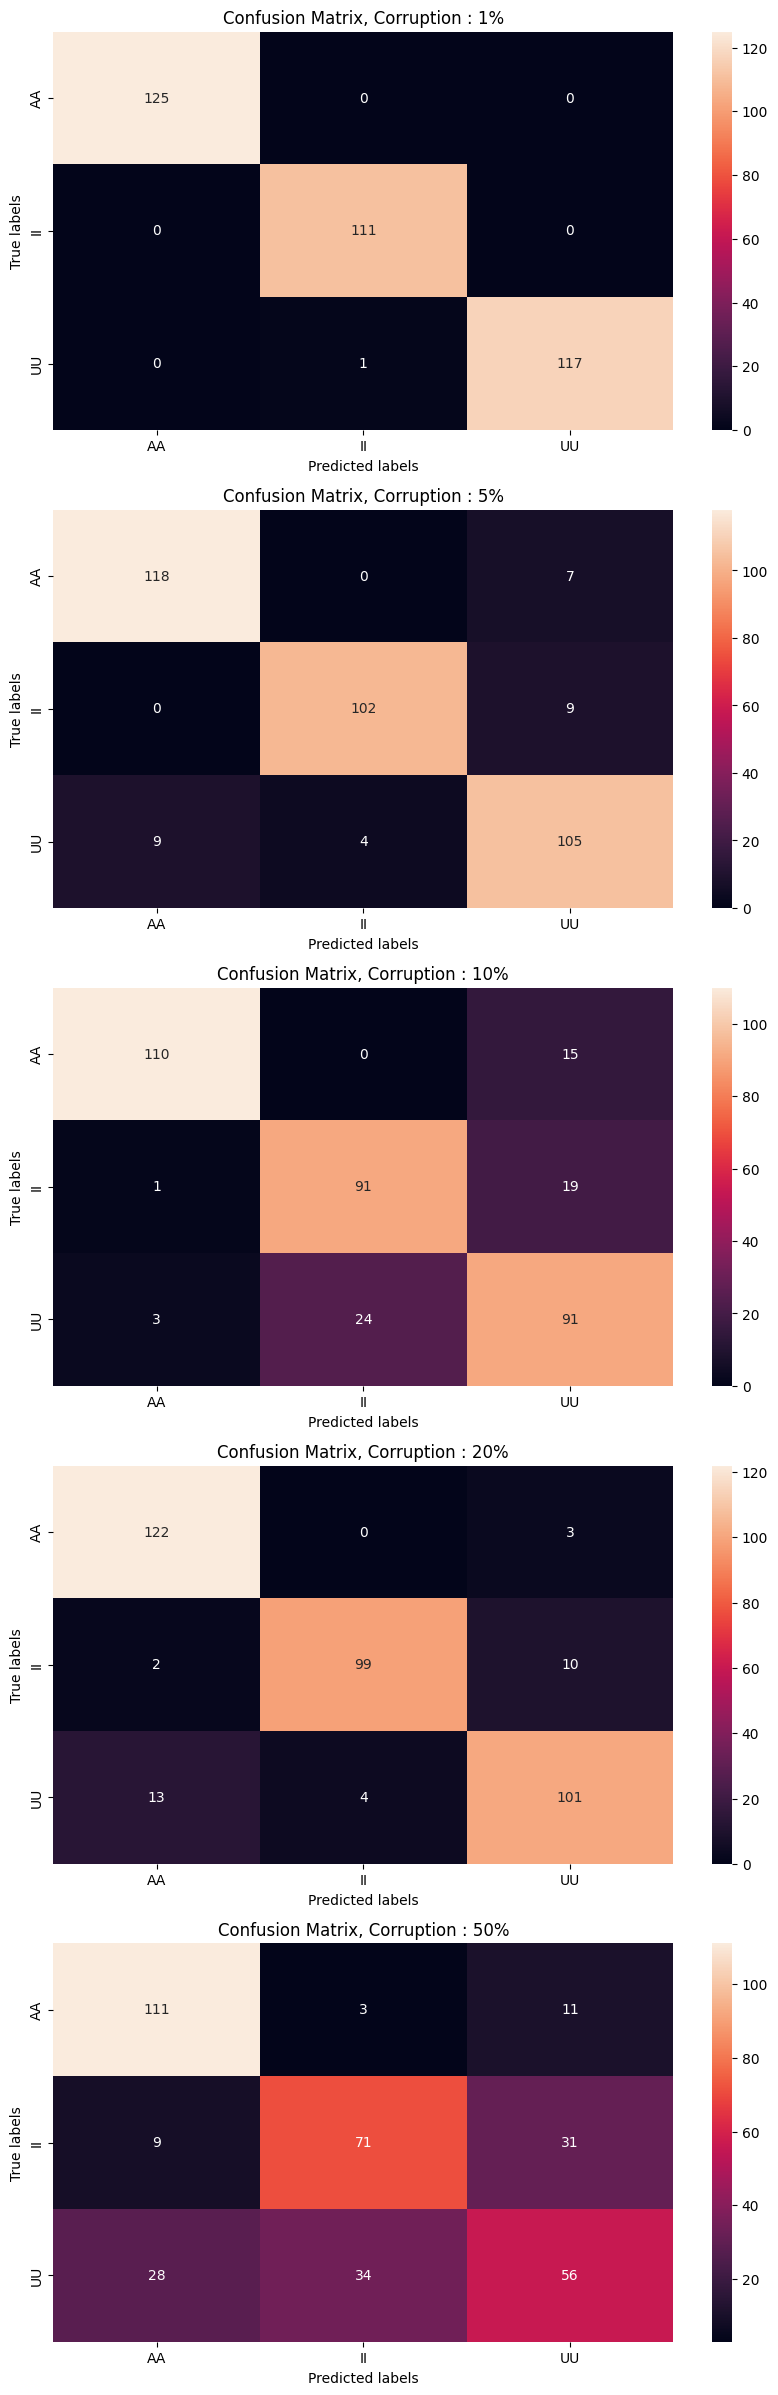

In [ ]:
classes = ['AA', 'II', 'UU']
fig, ax = plt.subplots(5,1,figsize=(10,30))

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(5,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix, Corruption : {corruption_list[i]}%')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

### **(e) Using Using Time Scaled Clean Speech**

In [ ]:
# Creating Spectrogram Datasets

NPERSEG = 256
WINDOW = 'hann'

def get_time_scaled_spectrogram_dataset(audio_dataset, sampling_rate, nperseg, window, scale_factor):

    X = []

    for signal in audio_dataset:

        # f, t, audio_spectrogram = scipy.signal.spectrogram(signal, sampling_rate, nperseg = nperseg, noverlap = 0, mode = 'psd', window = window)
        audio_spectrogram = np.abs(librosa.phase_vocoder(librosa.stft(y = signal, n_fft = NPERSEG, hop_length=256, window = 'hann'), rate = scale_factor))
        X.append(audio_spectrogram)

    return np.array(X)

In [ ]:
cf_matrix_list = []
for scale_factor in [1.2, 0.8]:

    time_scaled_clean_spectrogram_train_vowels_dataset = get_time_scaled_spectrogram_dataset(clean_train_vowels_data, clean_train_vowels_sampling_rate, NPERSEG, WINDOW, scale_factor)
    time_scaled_clean_spectrogram_test_vowels_dataset = get_time_scaled_spectrogram_dataset(clean_test_vowels_data, clean_test_vowels_sampling_rate, NPERSEG, WINDOW, scale_factor)


    # Preparing Training and Testing Dataset
    x_train,  y_train = time_scaled_clean_spectrogram_train_vowels_dataset.copy(), clean_train_vowels_labels.copy()
    x_test, y_test = time_scaled_clean_spectrogram_test_vowels_dataset.copy(), clean_test_vowels_labels.copy()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape

    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Time Scale Factor : {scale_factor}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

12/12 [==============================] - 0s 5ms/step
Time Scale Factor : 1.2, Test accuracy: 0.980225988700565
12/12 [==============================] - 0s 13ms/step
Time Scale Factor : 0.8, Test accuracy: 0.9971751412429378


<ipython-input-51-ae94eea94879>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot(2,1,i+1)


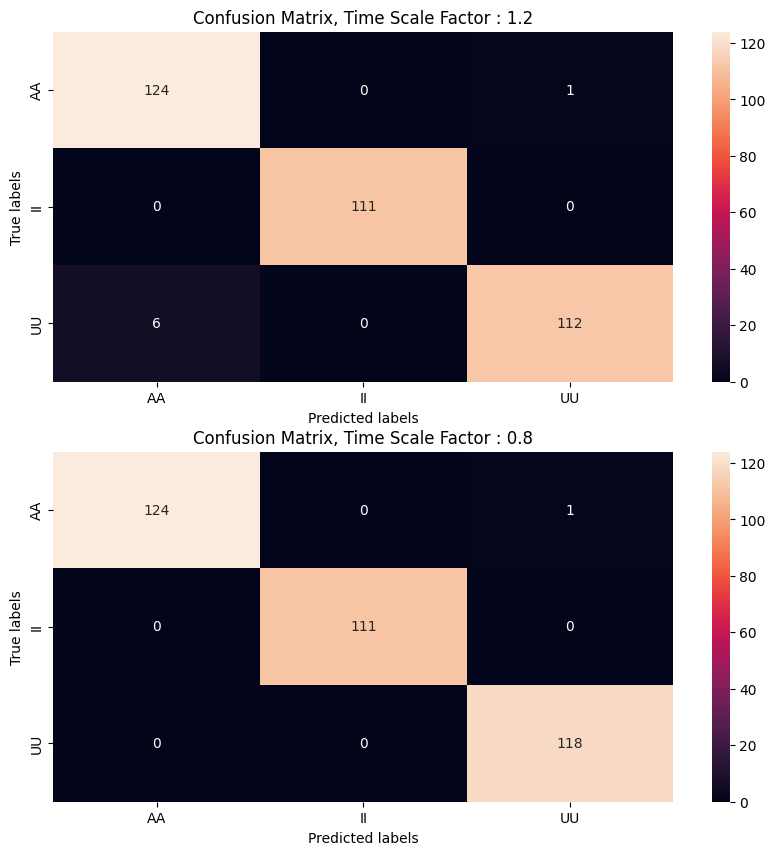

In [ ]:
classes = ['AA', 'II', 'UU']
fig, ax = plt.subplots(5,1,figsize=(10,10))
scale_list = [1.2,0.8]

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(2,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix, Time Scale Factor : {scale_list[i]}')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

### **(f) Using Reverberation added Clean Speech**

In [ ]:
reverbs = np.random.choice(list(Reverb.keys()), size = (3), replace = False)

def get_reverb_dataset(dataset, reverb):

    X = []

    for audio in dataset:
        reverb_audio = np.convolve(audio, reverb)
        X.append(reverb_audio)

    return np.array(X)

In [ ]:
cf_matrix_list = []

NPERSEG = 256
WINDOW = 'hann'

for reverb in reverbs:

    reverb_clean_train_vowels_dataset = get_reverb_dataset(clean_train_vowels_data, Reverb[reverb])
    reverb_clean_test_vowels_dataset = get_reverb_dataset(clean_test_vowels_data, Reverb[reverb])

    reverb_clean_train_spectrogram_vowels_dataset = get_spectrogram_dataset(reverb_clean_train_vowels_dataset, clean_train_vowels_sampling_rate, NPERSEG, WINDOW)
    reverb_clean_test_spectrogram_vowels_dataset = get_spectrogram_dataset(reverb_clean_test_vowels_dataset, clean_test_vowels_sampling_rate, NPERSEG, WINDOW)

    # Preparing Training and Testing Dataset

    x_train,  y_train = reverb_clean_train_spectrogram_vowels_dataset.copy(), clean_train_vowels_labels.copy()
    x_test, y_test = reverb_clean_test_spectrogram_vowels_dataset.copy(), clean_test_vowels_labels.copy()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape

    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Reverb : {reverb}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

12/12 [==============================] - 0s 17ms/step
Reverb : smallroom1_near_anglb, Test accuracy: 0.9943502824858758
12/12 [==============================] - 0s 9ms/step
Reverb : largeroom1_near_anglb, Test accuracy: 0.9915254237288136
12/12 [==============================] - 0s 9ms/step
Reverb : mediumroom1_far_anglb, Test accuracy: 0.9971751412429378


<ipython-input-33-f98dc983c864>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot(3,1,i+1)


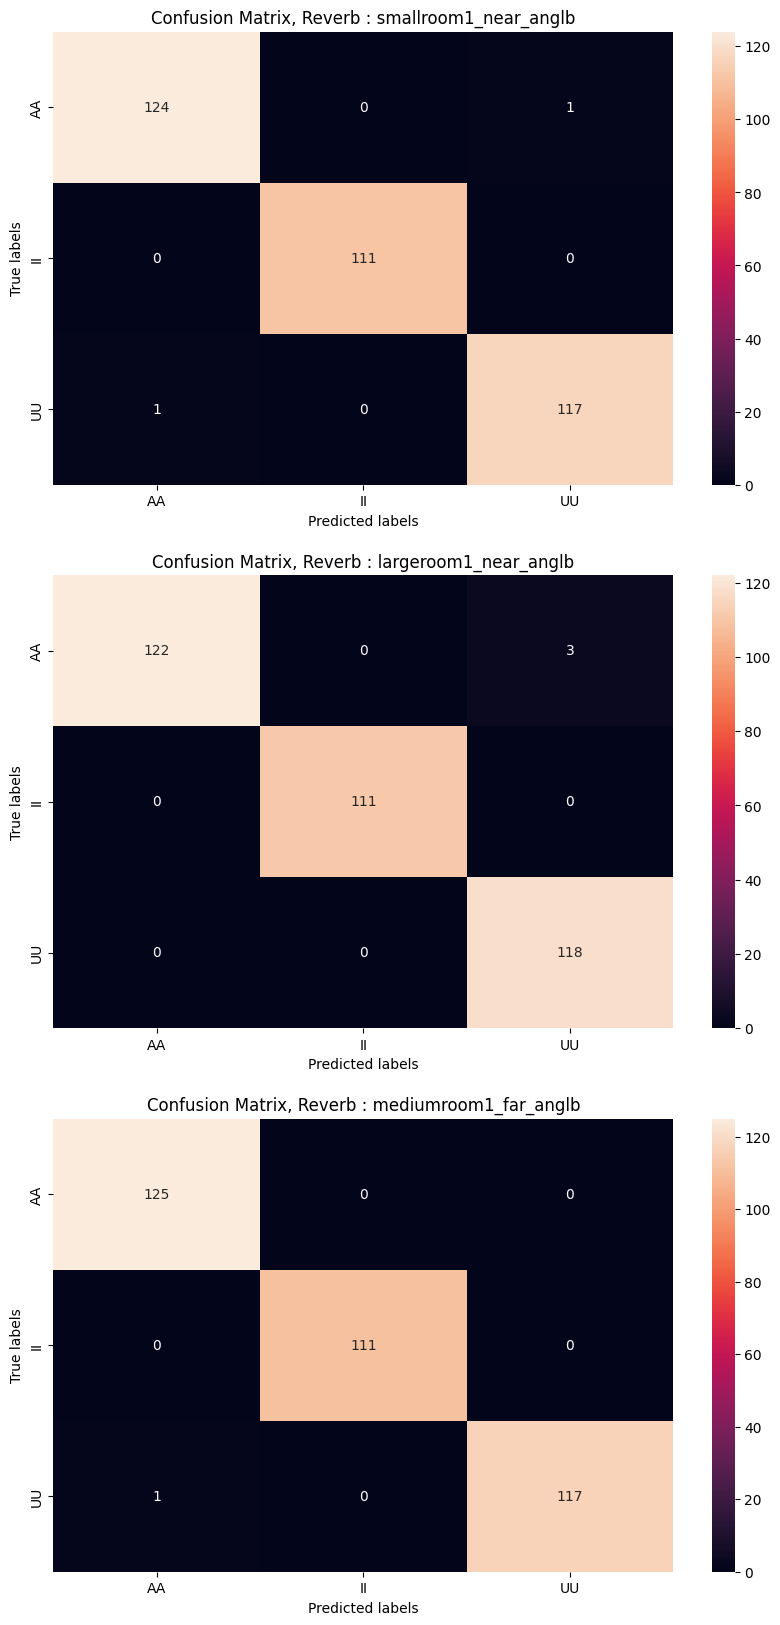

In [ ]:
classes = ['AA', 'II', 'UU']

fig, ax = plt.subplots(5,1,figsize=(10,20))

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(3,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix, Reverb : {reverbs[i]}')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

## **Consonant Classification**

###  **(a) Using Clean Spectrograms**

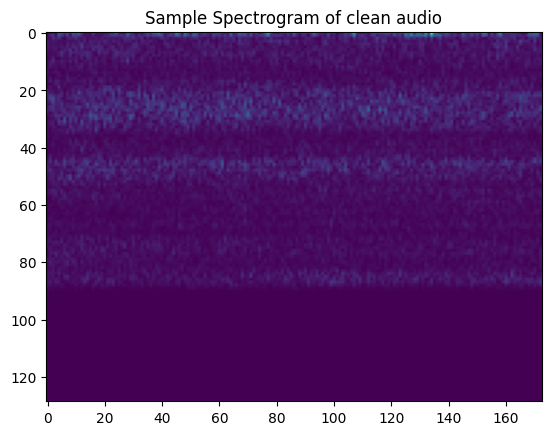

In [ ]:
# Preparing Training and Testing Dataset

x_train,  y_train = clean_spectrogram_train_consonants_dataset.copy(), clean_train_consonants_labels.copy()
x_test, y_test = clean_spectrogram_test_consonants_dataset.copy(), clean_test_consonants_labels.copy()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

n_classes = len(np.unique(y_train))
Image_shape = x_train[0].shape

plt.title('Sample Spectrogram of clean audio')
plt.imshow(x_train[0])

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 127, 171, 64)      640       
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 63, 85, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 61, 83, 32)        18464     
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 30, 41, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_33 (Flatten)        (None, 39360)             0         
                                                                 
 dense_66 (Dense)            (None, 128)             

In [ ]:
# Compile the model
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split = 0.25)

Epoch 1/10
4/4 [==============================] - 2s 161ms/step - loss: 3.2921 - accuracy: 0.4484 - val_loss: 0.4734 - val_accuracy: 0.7619
Epoch 2/10
4/4 [==============================] - 0s 60ms/step - loss: 0.6167 - accuracy: 0.7063 - val_loss: 0.8594 - val_accuracy: 0.5714
Epoch 3/10
4/4 [==============================] - 0s 54ms/step - loss: 0.7355 - accuracy: 0.6706 - val_loss: 0.7134 - val_accuracy: 0.7857
Epoch 4/10
4/4 [==============================] - 0s 52ms/step - loss: 0.5123 - accuracy: 0.8135 - val_loss: 0.4476 - val_accuracy: 0.8452
Epoch 5/10
4/4 [==============================] - 0s 54ms/step - loss: 0.3782 - accuracy: 0.8730 - val_loss: 0.2948 - val_accuracy: 0.8929
Epoch 6/10
4/4 [==============================] - 0s 54ms/step - loss: 0.2798 - accuracy: 0.9087 - val_loss: 0.2718 - val_accuracy: 0.8571
Epoch 7/10
4/4 [==============================] - 0s 54ms/step - loss: 0.1885 - accuracy: 0.9286 - val_loss: 0.2405 - val_accuracy: 0.8929
Epoch 8/10
4/4 [==========

In [ ]:
# Evaluate the model
y_pred = np.argmax(model.predict(x_test), axis=1)
test_accuracy = metrics.accuracy_score(y_test,y_pred)
print(f'Accuracy on the Test Dataset is :{test_accuracy:.4f}')

7/7 [==============================] - 0s 7ms/step
Accuracy on the Test Dataset is :0.7094


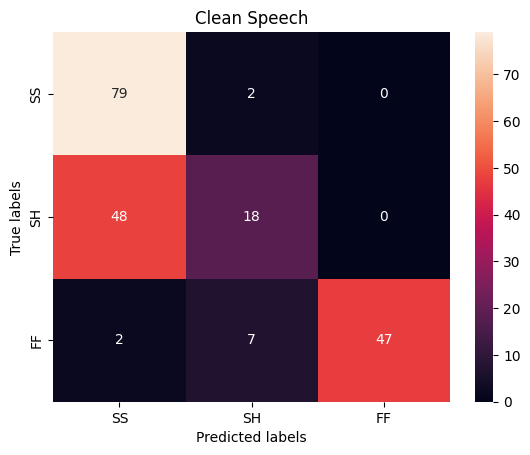

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test,y_pred)

classes = consonant_class_names

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Clean Speech');
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

###  **(b) Using Noisy Spectrograms**

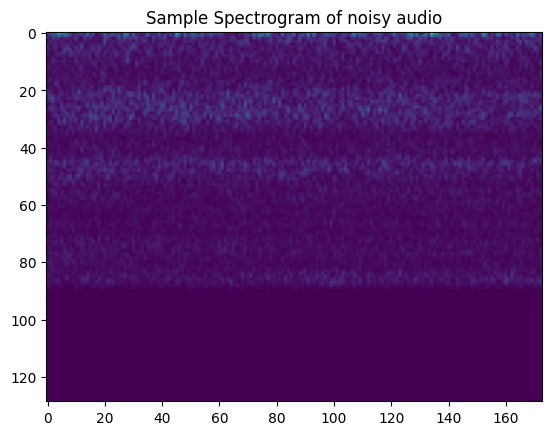

In [ ]:
# Preparing Training and Testing Dataset

x_train,  y_train = noisy_spectrogram_train_consonants_dataset, noisy_train_consonants_labels
x_test, y_test = noisy_spectrogram_test_consonants_dataset, noisy_test_consonants_labels

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

n_classes = len(np.unique(y_train))
Image_shape = x_train[0].shape

plt.title('Sample Spectrogram of noisy audio')
plt.imshow(x_train[0])

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 127, 171, 64)      640       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 63, 85, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 61, 83, 32)        18464     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 30, 41, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 39360)             0         
                                                                 
 dense_34 (Dense)            (None, 128)             

In [ ]:
# Compile the model
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split = 0.25)

Epoch 1/10
4/4 [==============================] - 2s 118ms/step - loss: 10.4575 - accuracy: 0.2778 - val_loss: 2.0411 - val_accuracy: 0.6429
Epoch 2/10
4/4 [==============================] - 0s 69ms/step - loss: 1.2592 - accuracy: 0.5476 - val_loss: 1.0046 - val_accuracy: 0.3929
Epoch 3/10
4/4 [==============================] - 0s 71ms/step - loss: 0.8629 - accuracy: 0.5714 - val_loss: 0.8828 - val_accuracy: 0.6190
Epoch 4/10
4/4 [==============================] - 0s 57ms/step - loss: 0.6828 - accuracy: 0.7024 - val_loss: 0.6649 - val_accuracy: 0.8452
Epoch 5/10
4/4 [==============================] - 0s 60ms/step - loss: 0.5222 - accuracy: 0.8413 - val_loss: 0.5564 - val_accuracy: 0.7619
Epoch 6/10
4/4 [==============================] - 0s 61ms/step - loss: 0.3988 - accuracy: 0.8611 - val_loss: 0.5082 - val_accuracy: 0.7738
Epoch 7/10
4/4 [==============================] - 0s 71ms/step - loss: 0.3158 - accuracy: 0.8968 - val_loss: 0.4379 - val_accuracy: 0.7976
Epoch 8/10
4/4 [=========

In [ ]:
# Evaluate the model
y_pred = np.argmax(model.predict(x_test), axis=1)
test_accuracy = metrics.accuracy_score(y_test,y_pred)
print(f'Accuracy on the Test Dataset is :{test_accuracy:.4f}')

7/7 [==============================] - 0s 6ms/step
Accuracy on the Test Dataset is :0.7488


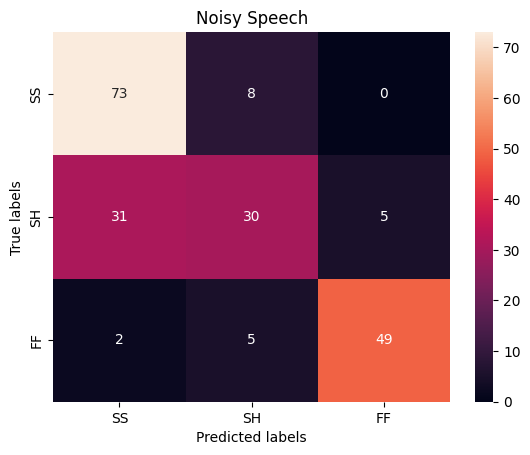

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test,y_pred)

classes = consonant_class_names

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Noisy Speech');
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

###  **(c) Using Corrupted Rows Spectrograms of Clean Speech**

In [ ]:
corruption_list = [1, 5, 10, 20, 50]

def corrupt_rows(dataset, percentage_of_corruption):

    for i,Sxx in enumerate(dataset):
        idx = random.sample(range(0, Sxx.shape[0]), int((percentage_of_corruption/100)*Sxx.shape[0]))
        Sxx[idx, :] = np.random.uniform(np.min(Sxx), np.max(Sxx), (len(idx),Sxx.shape[1]))
        dataset[i] = Sxx

    return dataset

cf_matrix_list = []

for corruption in corruption_list:

    # Preparing Training and Testing Dataset
    x_train,  y_train = clean_spectrogram_train_consonants_dataset.copy(), clean_train_consonants_labels.copy()
    x_test, y_test = clean_spectrogram_test_consonants_dataset.copy(), clean_test_consonants_labels.copy()

    x_train, x_test = corrupt_rows(x_train, corruption), corrupt_rows(x_test, corruption)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape


    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)


    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Percentage of Corruption : {corruption}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

7/7 [==============================] - 0s 6ms/step
Percentage of Corruption : 1, Test accuracy: 0.7438423645320197
7/7 [==============================] - 0s 5ms/step
Percentage of Corruption : 5, Test accuracy: 0.5320197044334976
7/7 [==============================] - 0s 7ms/step
Percentage of Corruption : 10, Test accuracy: 0.5862068965517241
7/7 [==============================] - 0s 7ms/step
Percentage of Corruption : 20, Test accuracy: 0.39901477832512317
7/7 [==============================] - 0s 5ms/step
Percentage of Corruption : 50, Test accuracy: 0.42857142857142855


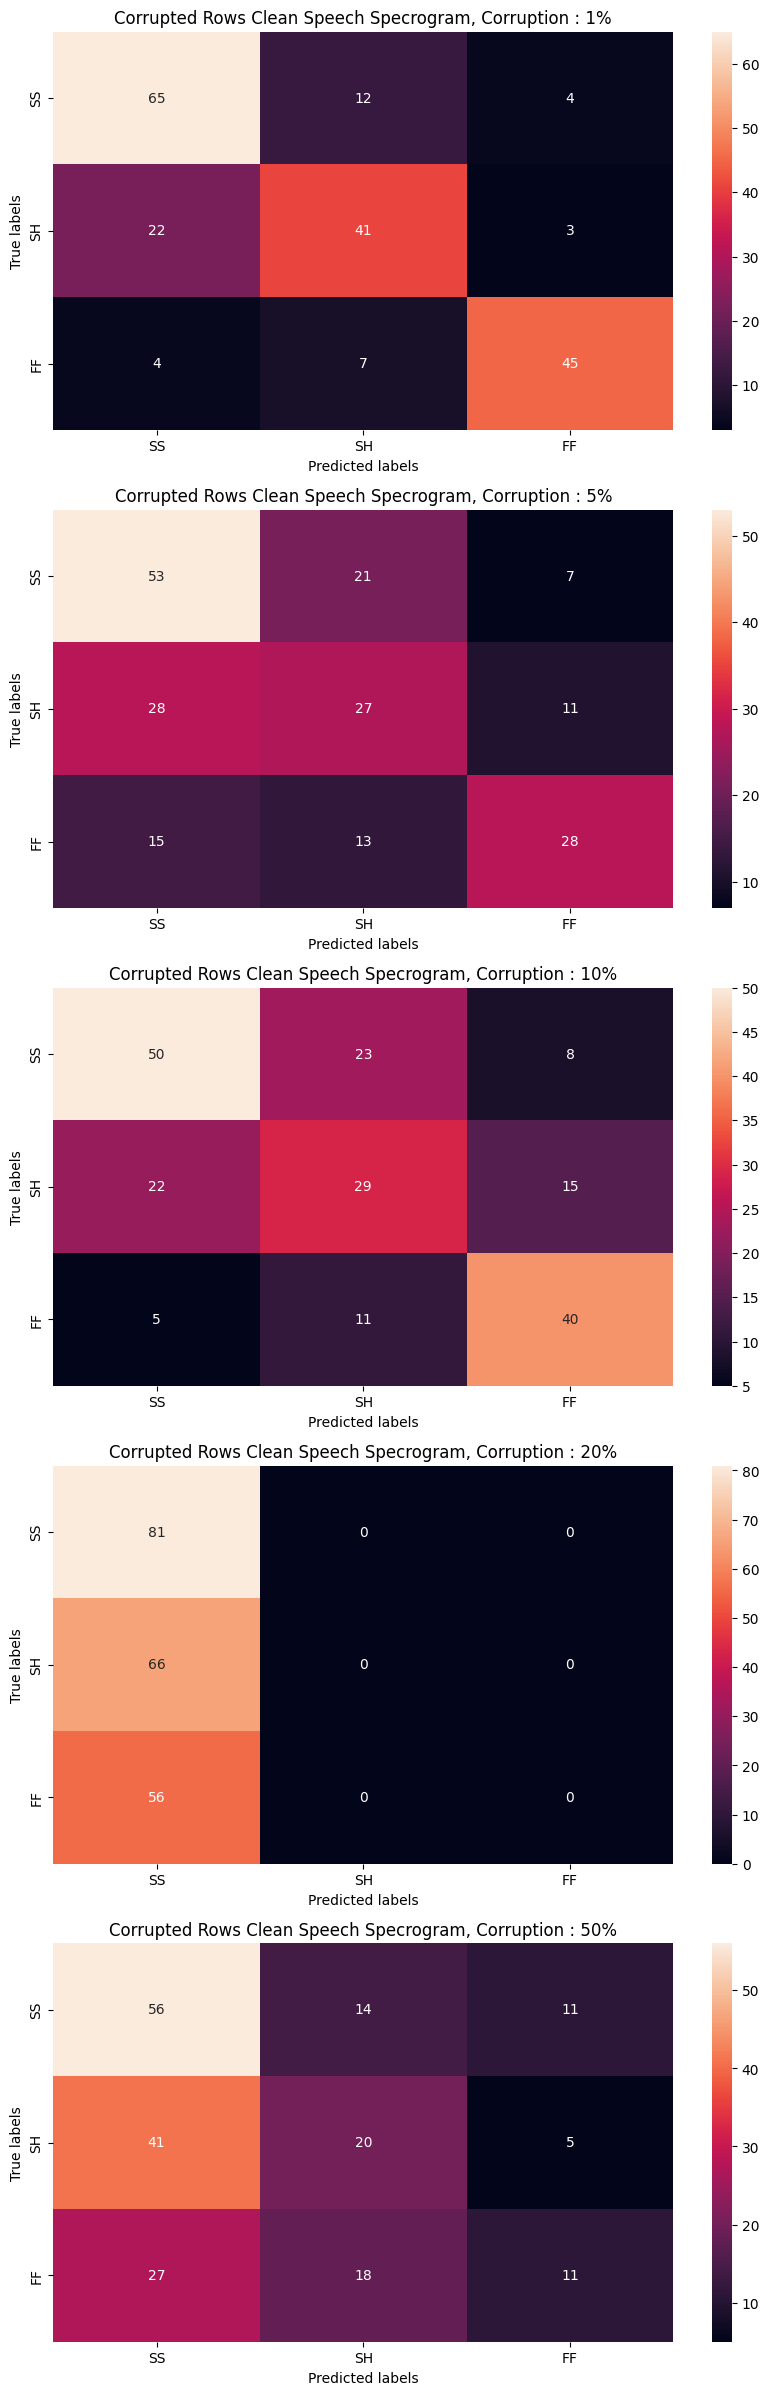

In [ ]:
classes = consonant_class_names

fig, ax = plt.subplots(5,1,figsize=(10,30))

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(5,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Corrupted Rows Clean Speech Specrogram, Corruption : {corruption_list[i]}%')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

### **(d) Using Corrupted Columns Spectrograms of Clean Speech**

In [ ]:
corruption_list = [1, 5, 10, 20, 50]

def corrupt_columns(dataset, percentage_of_corruption):

    for i,Sxx in enumerate(dataset):
        idx = random.sample(range(0, Sxx.shape[1]), int((percentage_of_corruption/100)*Sxx.shape[1]))
        Sxx[:, idx] = np.random.uniform(np.min(Sxx), np.max(Sxx), (Sxx.shape[0],len(idx)))
        dataset[i] = Sxx

    return dataset

cf_matrix_list = []

for corruption in corruption_list:

    # Preparing Training and Testing Dataset
    x_train,  y_train = clean_spectrogram_train_consonants_dataset.copy(), clean_train_consonants_labels.copy()
    x_test, y_test = clean_spectrogram_test_consonants_dataset.copy(), clean_test_consonants_labels.copy()

    x_train, x_test = corrupt_columns(x_train, corruption), corrupt_columns(x_test, corruption)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape


    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Percentage of Corruption : {corruption}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

7/7 [==============================] - 0s 6ms/step
Percentage of Corruption : 1, Test accuracy: 0.6502463054187192
7/7 [==============================] - 0s 8ms/step
Percentage of Corruption : 5, Test accuracy: 0.645320197044335
7/7 [==============================] - 0s 7ms/step
Percentage of Corruption : 10, Test accuracy: 0.4039408866995074
7/7 [==============================] - 0s 8ms/step
Percentage of Corruption : 20, Test accuracy: 0.5763546798029556
7/7 [==============================] - 0s 9ms/step
Percentage of Corruption : 50, Test accuracy: 0.5812807881773399


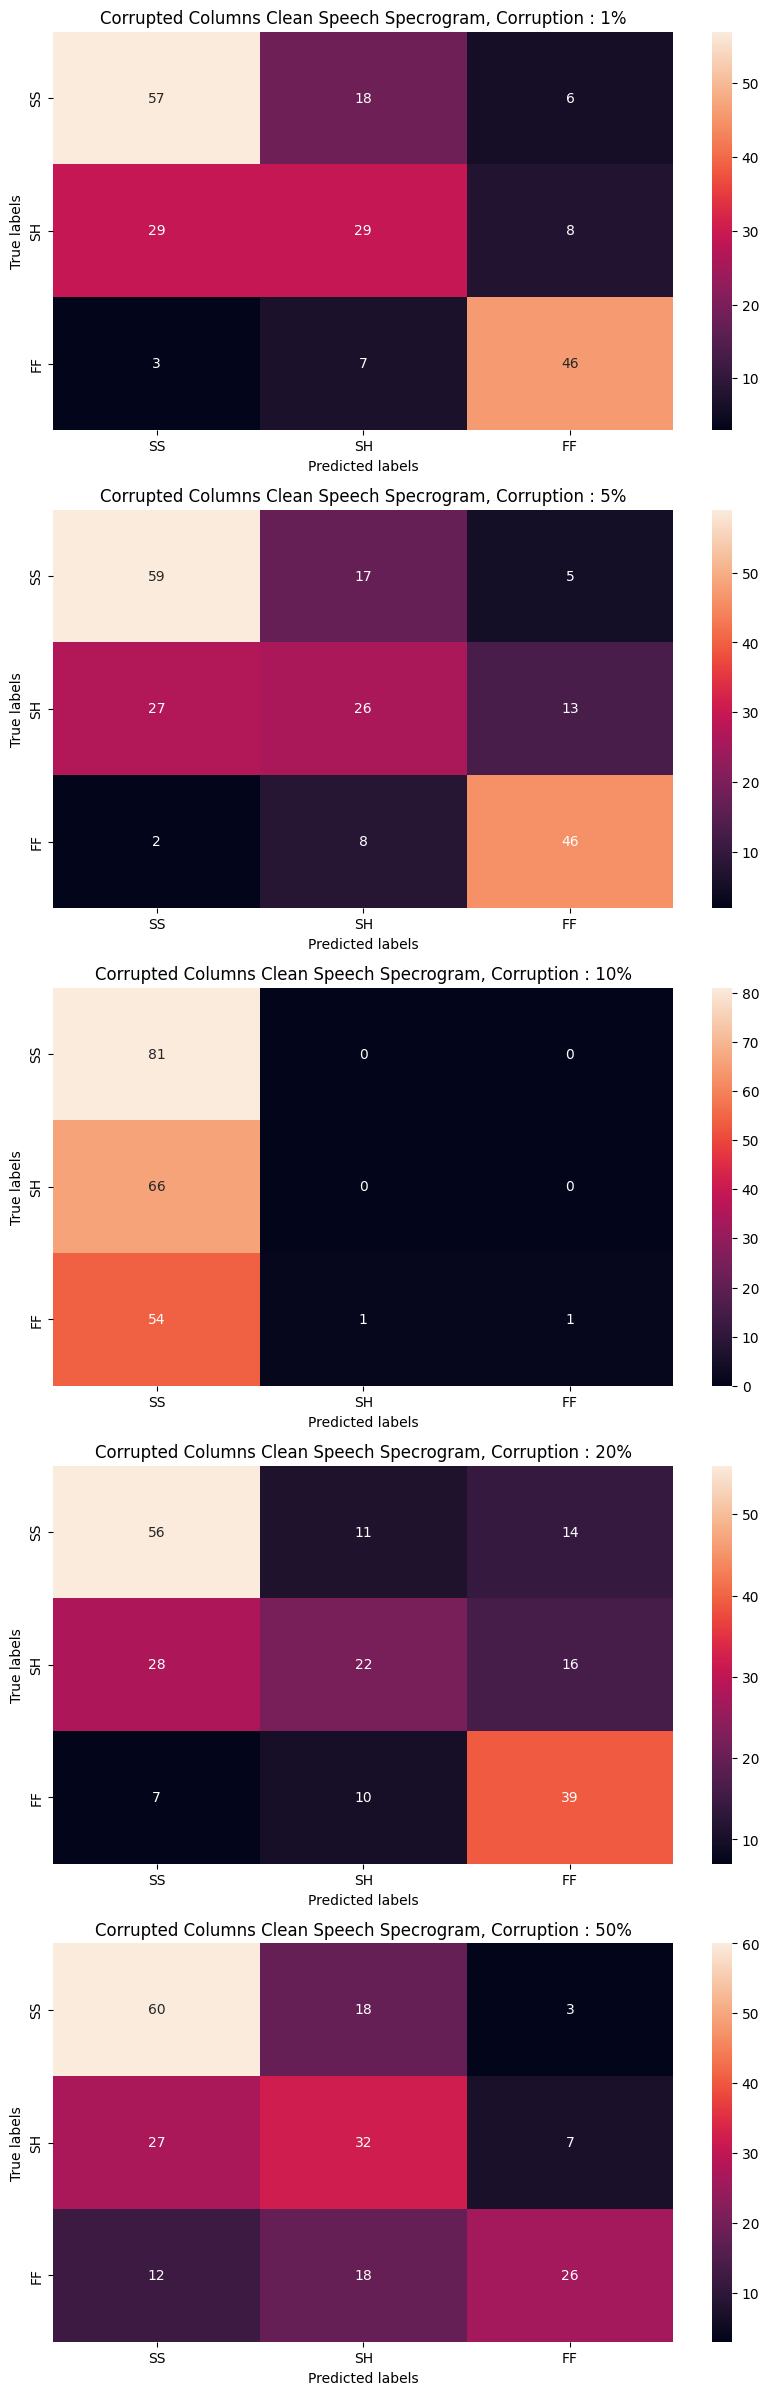

In [ ]:
classes = consonant_class_names

fig, ax = plt.subplots(5,1,figsize=(10,30))

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(5,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Corrupted Columns Clean Speech Specrogram, Corruption : {corruption_list[i]}%')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

### **(e) Using Time Scaled Clean Speech**

In [ ]:
# Creating Spectrogram Datasets

NPERSEG = 256
WINDOW = 'hann'

def get_time_scaled_spectrogram_dataset(audio_dataset, sampling_rate, nperseg, window, scale_factor):

    X = []

    for signal in audio_dataset:

        # f, t, audio_spectrogram = scipy.signal.spectrogram(signal, sampling_rate, nperseg = nperseg, noverlap = 0, mode = 'psd', window = window)
        audio_spectrogram = np.abs(librosa.phase_vocoder(librosa.stft(y = signal, n_fft = NPERSEG, hop_length=256, window = 'hann'), rate = scale_factor))
        X.append(audio_spectrogram)

    return np.array(X)

In [ ]:
cf_matrix_list = []
for scale_factor in [1.2, 0.8]:

    time_scaled_clean_spectrogram_train_consonants_dataset = get_time_scaled_spectrogram_dataset(clean_train_consonants_data, clean_train_consonants_sampling_rate, NPERSEG, WINDOW, scale_factor)
    time_scaled_clean_spectrogram_test_consonants_dataset = get_time_scaled_spectrogram_dataset(clean_test_consonants_data, clean_test_consonants_sampling_rate, NPERSEG, WINDOW, scale_factor)


    # Preparing Training and Testing Dataset
    x_train,  y_train = time_scaled_clean_spectrogram_train_consonants_dataset.copy(), clean_train_consonants_labels.copy()
    x_test, y_test = time_scaled_clean_spectrogram_test_consonants_dataset.copy(), clean_test_consonants_labels.copy()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape

    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Time Scale Factor : {scale_factor}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

7/7 [==============================] - 0s 5ms/step
Time Scale Factor : 1.2, Test accuracy: 0.6847290640394089
7/7 [==============================] - 0s 8ms/step
Time Scale Factor : 0.8, Test accuracy: 0.729064039408867


<ipython-input-68-34f74838c46a>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot(2,1,i+1)


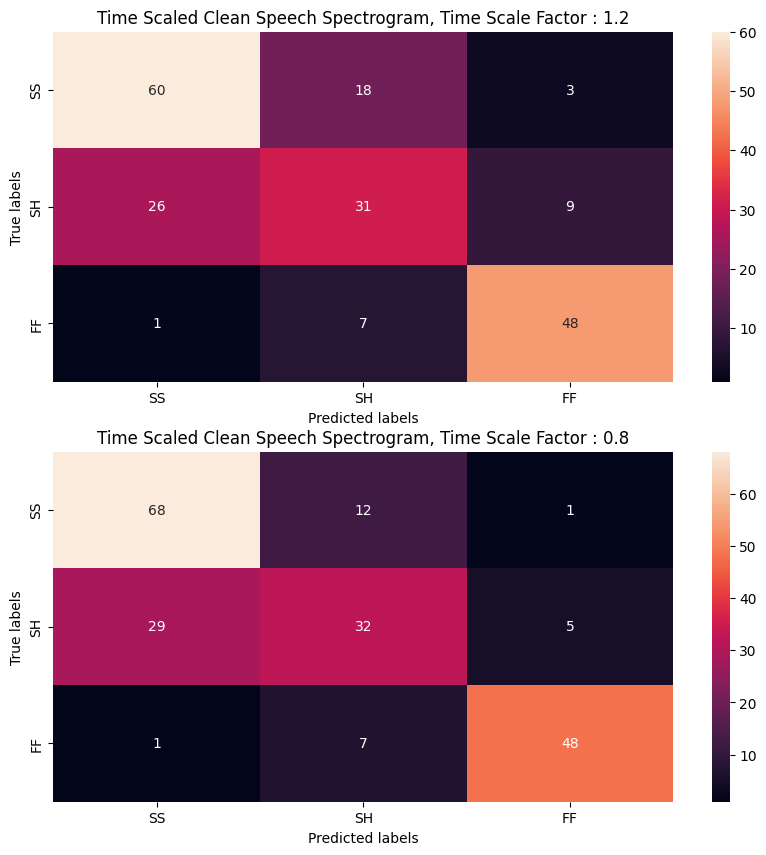

In [ ]:
classes = consonant_class_names

fig, ax = plt.subplots(5,1,figsize=(10,10))
scale_list = [1.2,0.8]

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(2,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Time Scaled Clean Speech Spectrogram, Time Scale Factor : {scale_list[i]}')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)

### **(f) Using Reverb Added Clean Speech**

In [ ]:
reverbs = np.random.choice(list(Reverb.keys()), size = (3), replace = False)

def get_reverb_dataset(dataset, reverb):

    X = []

    for audio in dataset:
        reverb_audio = np.convolve(audio, reverb)
        X.append(reverb_audio)

    return np.array(X)

In [ ]:
cf_matrix_list = []

NPERSEG = 256
WINDOW = 'hann'

for reverb in reverbs:

    reverb_clean_train_consonants_dataset = get_reverb_dataset(clean_train_consonants_data, Reverb[reverb])
    reverb_clean_test_consonants_dataset = get_reverb_dataset(clean_test_consonants_data, Reverb[reverb])

    reverb_clean_train_spectrogram_consonants_dataset = get_spectrogram_dataset(reverb_clean_train_consonants_dataset, clean_train_consonants_sampling_rate, NPERSEG, WINDOW)
    reverb_clean_test_spectrogram_consonants_dataset = get_spectrogram_dataset(reverb_clean_test_consonants_dataset, clean_test_consonants_sampling_rate, NPERSEG, WINDOW)

    # Preparing Training and Testing Dataset

    x_train,  y_train = reverb_clean_train_spectrogram_consonants_dataset.copy(), clean_train_consonants_labels.copy()
    x_test, y_test = reverb_clean_test_spectrogram_consonants_dataset.copy(), clean_test_consonants_labels.copy()

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

    n_classes = len(np.unique(y_train))
    Image_shape = x_train[0].shape

    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(Image_shape[0], Image_shape[1], 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam' , metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose = 0)

    # Evaluate the model
    y_pred = np.argmax(model.predict(x_test), axis=1)
    test_accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'Reverb : {reverb}, Test accuracy: {test_accuracy}')

    cf_matrix_list.append(metrics.confusion_matrix(y_test,y_pred))

7/7 [==============================] - 0s 10ms/step
Reverb : smallroom1_far_angla, Test accuracy: 0.6748768472906403
7/7 [==============================] - 0s 8ms/step
Reverb : smallroom1_far_anglb, Test accuracy: 0.729064039408867
7/7 [==============================] - 0s 8ms/step
Reverb : largeroom1_far_angla, Test accuracy: 0.7487684729064039


<ipython-input-71-8ada570bd659>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot(3,1,i+1)


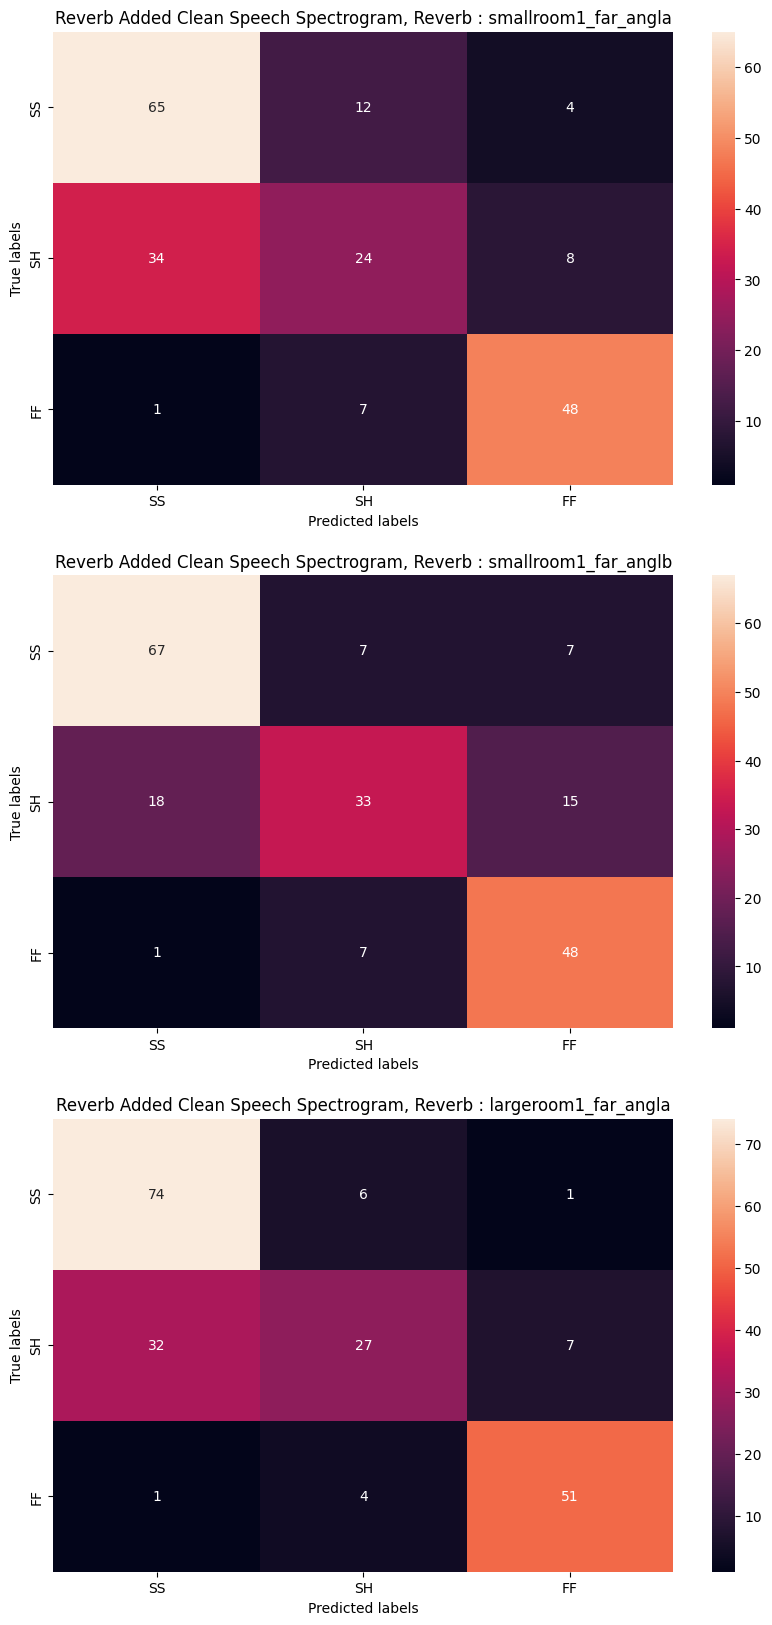

In [ ]:
classes = consonant_class_names

fig, ax = plt.subplots(5,1,figsize=(10,20))

for i,cf_matrix in enumerate(cf_matrix_list):

    ax= plt.subplot(3,1,i+1)
    sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(f'Reverb Added Clean Speech Spectrogram, Reverb : {reverbs[i]}')
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes)